 #### Coded by: Vikranth

In [1]:
import pandas as pd
from sklearn import ensemble
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib notebook

(180000, 15)
(86757, 3)
(86757, 15)


<IPython.core.display.Javascript object>


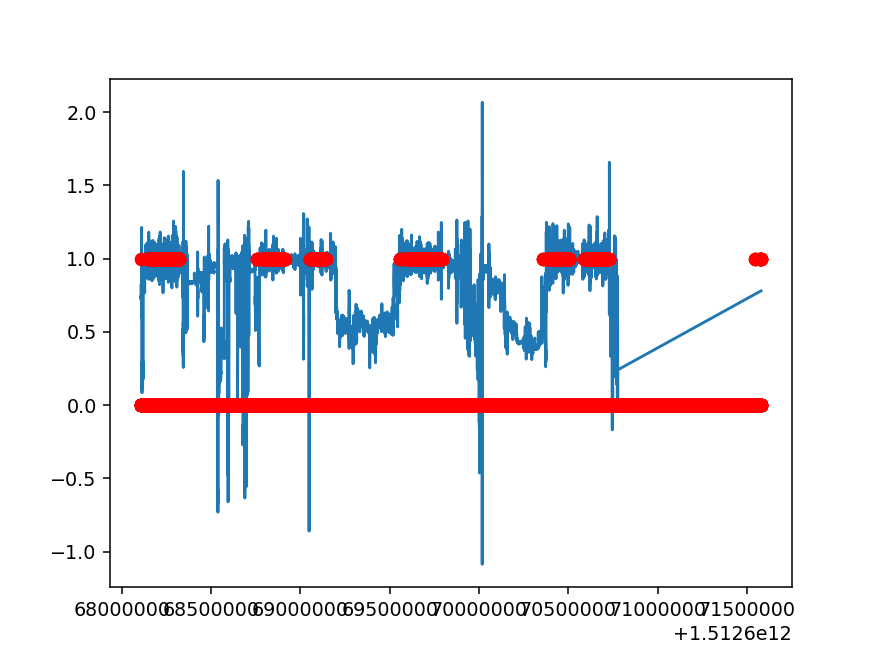

<IPython.core.display.Javascript object>


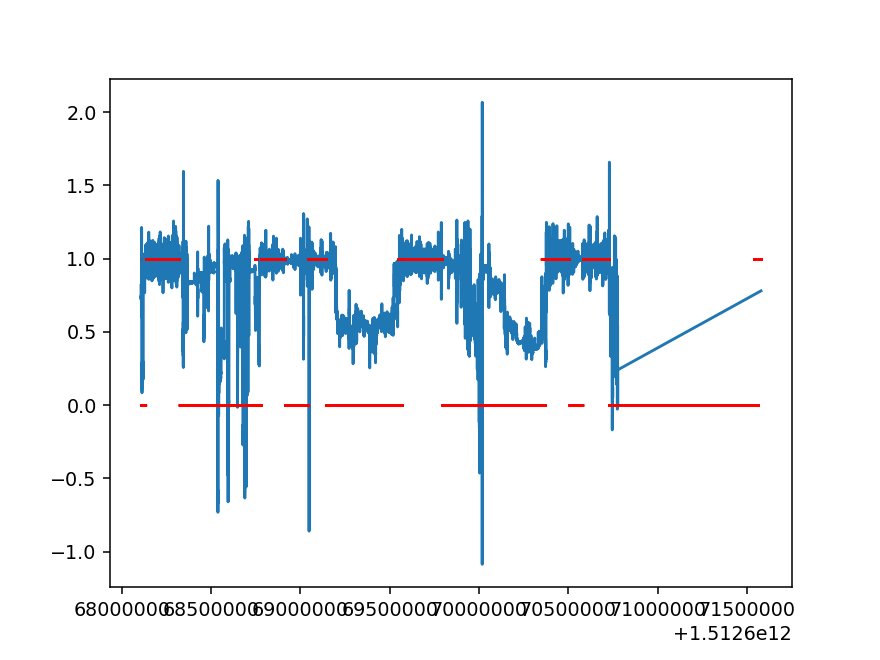

In [2]:
participant_1 = pd.read_pickle('Participant_1.pkl')
#print(participant_1)
labels_1 = np.load('Participant_1_label.npy')
#print(labels_1)

start_time = labels_1[0,0]
end_time = labels_1[-1,0]

dataset = np.copy(participant_1.values)
print(dataset.shape)
print(labels_1.shape)

delta = 40
dataset = dataset[dataset[:,0] >= start_time,:]
dataset = dataset[dataset[:,0] < end_time + delta,:]
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],labels_1[:,2],'ro')
plt.show()

type_window = 10000
k = int(type_window/delta)
l = len(labels_1)
typing_labels = np.zeros((l,1))
for i in range(0,l):
    if i<(l-k):
        typing_labels[i] = np.amax(labels_1[i:i+k,2])
    else:
        typing_labels[i] = np.amax(labels_1[i:,2])
#print(typing_labels)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],typing_labels,'r.', ms = 0.1)
plt.show()

Counter({0.0: 65815, 1.0: 17721, 2.0: 3221})
(65815, 1)
(65815, 15)


<IPython.core.display.Javascript object>


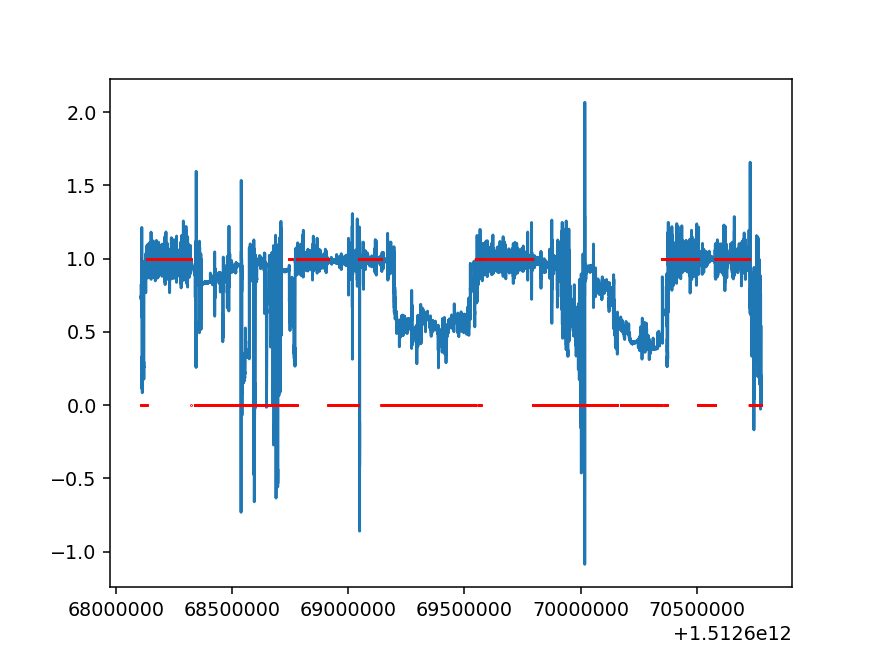

In [3]:
# Remove Missing Data:
missing_1 = dataset[:,13] + dataset[:,14]
print(Counter(missing_1))

dataset = dataset[np.where(missing_1 == 0)]
typing_labels = typing_labels[np.where(missing_1 == 0)]

print(typing_labels.shape)
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],typing_labels,'r.', ms = 0.1)
plt.show()

In [4]:
dataset_cp = np.copy(dataset[:,1:13])

n_samples, d = dataset_cp.shape
window = 20
stride = 5

data_slide = np.zeros((int((n_samples-window)/stride)+1,window,d))
typing_labels_cp = np.zeros((int((n_samples-window)/stride)+1,1))
k=0
for i in range(0,n_samples-window,stride): #400ms
    data_slide[k,:,:] = dataset_cp[i:i+window,:]
    typing_labels_cp[k] = np.amax(typing_labels[i:i+window])
    k=k+1
    
print (data_slide.shape)
print(typing_labels_cp.shape)

(13160, 20, 12)
(13160, 1)


In [34]:
import numpy as np
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Permute, Reshape
from keras import backend as K

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [7]:
z = 13000
X_train0 = data_slide[:z]
Y_train = typing_labels_cp[0:z].reshape(-1).astype(np.uint8)
X_test0 = data_slide[z:]
Y_test = typing_labels_cp[z:]
print(np.shape(X_train0))
print(np.shape(Y_train))
print(np.shape(X_test0))
print(np.shape(Y_test))

(13000, 20, 12)
(13000,)
(160, 20, 12)
(160, 1)


In [8]:
num_classes = 2
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [9]:
def _data_reshaping(X_tr, X_va, network_type):
    _, win_len, dim = X_tr.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
        
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_tr = np.swapaxes(X_tr,1,2)
        X_va = np.swapaxes(X_va,1,2)

        X_tr = np.reshape(X_tr, (-1, dim, win_len, 1))
        X_va = np.reshape(X_va, (-1, dim, win_len, 1))
        
    if network_type=='MLP':
        print('MLP...')
        X_tr = np.reshape(X_tr, (-1, dim*win_len))
        X_va = np.reshape(X_va, (-1, dim*win_len))
    
    return X_tr, X_va


In [46]:
def model_variant(model, num_feat_map, dim, network_type,p):
    print(network_type)
    if network_type == 'ConvLSTM':
        model.add(Permute((2, 1, 3))) # for swap-dimension
        model.add(Reshape((-1,num_feat_map*dim)))
        model.add(LSTM(32, return_sequences=False, stateful=False))
        model.add(Dropout(p))
    if network_type == 'CNN':
        
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(BatchNormalization()) #added
        model.add(Dropout(p))

        
def model_conv(model, num_feat_map,p,b):
    model.add(Conv2D(num_feat_map, kernel_size=(1, 3),    # Original Kernel size(1,5)
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    if (b==1):
        model.add(BatchNormalization()) #added
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    model.add(Conv2D(num_feat_map, kernel_size=(1, 3), activation='relu',padding='same'))  # Original Kernel size(1,5)
    if (b==1):
        model.add(BatchNormalization()) #added
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    
def model_LSTM(model,p):
    model.add(LSTM(num_hidden_lstm, 
               input_shape=(win_len,dim), 
               return_sequences=True))
    model.add(Dropout(p))
    model.add(LSTM(num_hidden_lstm, return_sequences=False))
    model.add(Dropout(p))

def model_MLP(model, num_hidden_mlp,p):
    model.add(Dense(num_hidden_mlp, activation='relu', input_shape=(dim*win_len,)))
    model.add(Dropout(p))
    model.add(Dense(num_hidden_mlp, activation='relu'))
    model.add(Dropout(p))
    
def model_output(model):
    model.add(Dense(num_classes, activation='softmax'))
    

In [47]:
batch_size = 1024
num_feat_map = 16
num_hidden_mlp = 128
num_hidden_lstm = 64

#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#network_type = 'MLP'
_, win_len, dim = X_train0.shape
print(win_len)
print(dim)

X_train, X_test = _data_reshaping(X_train0, X_test0, network_type)


20
12
ConvLSTM


In [49]:
p=0.3 #Dropout
b = 1 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
if network_type=='MLP': 
    model_MLP(model, num_hidden_mlp,p) 
       
model_output(model)    
model.summary()


building the model ... 
ConvLSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 12, 20, 16)        64        
_________________________________________________________________
batch_normalization_16 (Batc (None, 12, 20, 16)        64        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 10, 16)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 12, 10, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 10, 16)        784       
_________________________________________________________________
batch_normalization_17 (Batc (None, 12, 10, 16)        64        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 5, 

In [50]:
epochs = 100

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

H = model.fit(X_train, Y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_test, Y_test))


Train on 13000 samples, validate on 160 samples
Epoch 1/100
13000/13000 [==============================] - 12s - loss: 0.6209 - acc: 0.6447 - val_loss: 0.9220 - val_acc: 0.2937
Epoch 2/100
13000/13000 [==============================] - 10s - loss: 0.4693 - acc: 0.7884 - val_loss: 0.8113 - val_acc: 0.4437
Epoch 3/100
13000/13000 [==============================] - 10s - loss: 0.4042 - acc: 0.8216 - val_loss: 0.4022 - val_acc: 0.8125
Epoch 4/100
13000/13000 [==============================] - 10s - loss: 0.3646 - acc: 0.8462 - val_loss: 0.2334 - val_acc: 0.9688
Epoch 5/100
13000/13000 [==============================] - 10s - loss: 0.3383 - acc: 0.8581 - val_loss: 0.1628 - val_acc: 0.9875
Epoch 6/100
13000/13000 [==============================] - 10s - loss: 0.3264 - acc: 0.8612 - val_loss: 0.1282 - val_acc: 0.9875
Epoch 7/100
13000/13000 [==============================] - 10s - loss: 0.3151 - acc: 0.8669 - val_loss: 0.1087 - val_acc: 0.9937
Epoch 8/100
13000/13000 [========================

In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(Y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))


[[149  11]
 [  0   0]]
the mean-f1 score: 0.48


C:\Users\Vikranth\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


<IPython.core.display.Javascript object>


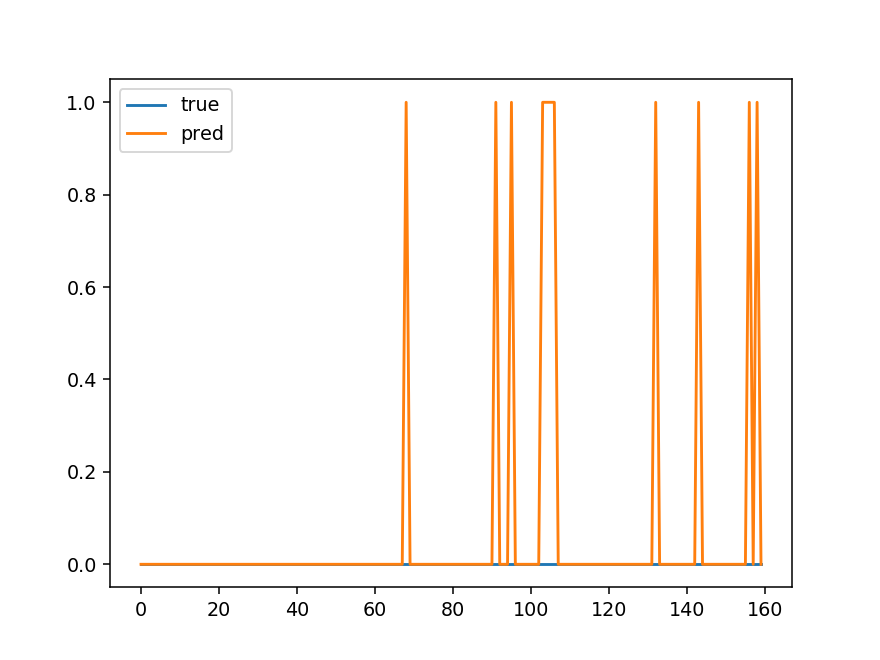

In [52]:
plt.figure()
plt.plot(y_true, label="true")
plt.plot(y_pred, label="pred")

#plt.plot(typing_labels_cp[60000:], label="label")

plt.legend()
plt.show()

In [53]:
model.save('Convbn_LSTM_100.h5')

In [108]:
l = len(y_pred)
for x in range(0,l):
    if y_pred[x] == 0:
        y_pred[x-100:x] = 0


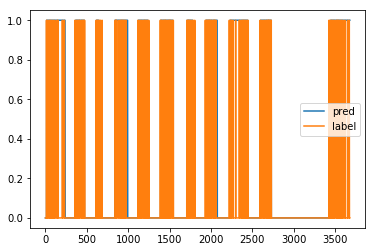

In [112]:
#plt.plot(y_true, label="true")
plt.plot(y_pred, label="pred")
plt.plot(labels[26100:], label="label")
plt.legend()
plt.show()

In [102]:
points = np.where(y_pred[:-1] - y_pred[1:] == -1)[0]
print(points)

[  13  363  615  805  839 1122 1392 1700 1712 1883 1940 2230 2600 3047 3358
 3446]


In [117]:
np.savetxt("Conv_LSTM_ypred.csv", y_pred , delimiter=",")
np.savetxt("Conv_LSTM_labels.csv", labels[26100:] , delimiter=",")

In [125]:
np.sort(np.diff(keylog_np[:,2]))

array([64, 70, 72, 75, 75, 76, 76, 80, 83, 83, 84, 85, 87, 87, 89, 89, 91,
       91, 91, 92, 92, 92, 93, 95, 96, 96, 97, 97, 99, 100, 100, 100, 101,
       101, 102, 104, 104, 104, 104, 105, 105, 106, 106, 107, 107, 107,
       107, 108, 108, 108, 108, 108, 109, 110, 111, 111, 112, 113, 113,
       114, 115, 116, 117, 117, 117, 119, 120, 120, 120, 120, 121, 121,
       122, 123, 123, 123, 124, 124, 124, 126, 126, 127, 127, 128, 128,
       128, 128, 129, 129, 129, 129, 129, 130, 130, 130, 130, 131, 131,
       131, 132, 132, 133, 133, 133, 134, 134, 135, 135, 136, 136, 136,
       137, 137, 137, 137, 138, 138, 138, 139, 139, 139, 139, 140, 140,
       140, 141, 141, 142, 142, 142, 143, 143, 144, 144, 144, 145, 145,
       146, 147, 147, 147, 147, 147, 147, 147, 148, 148, 148, 148, 149,
       149, 150, 150, 151, 152, 152, 152, 153, 153, 154, 155, 156, 156,
       156, 157, 157, 158, 158, 159, 159, 160, 160, 161, 161, 162, 162,
       163, 164, 164, 164, 164, 164, 165, 165, 166, 166, 1

In [127]:
pause = [1057, 1276, 1279, 1280, 1286, 1291,
       1300, 1304, 1332, 1352, 1376, 1398, 1398, 1401, 1407, 1412, 1413,
       1420, 1424, 1428, 1450, 1453, 1453, 1464, 1479, 1505, 1553, 1594,
       1617, 1618, 1631, 1638, 1645, 1659, 1713, 1825, 1846, 1861, 1872,
       1879, 1896, 1923, 1959, 2022, 2040, 2144, 2193, 2224, 2264, 2273,
       2384, 3026, 3151, 3157, 3830, 5301, 6978, 9050, 9447, 11084]
print(np.mean(pause))
print(np.std(pause))


2298.91666667
1988.94551871


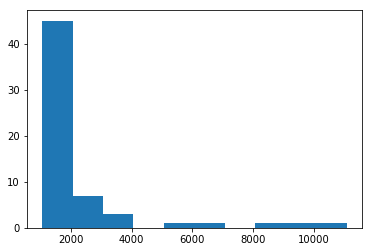

In [128]:
plt.hist(pause)
plt.show()